<a href="https://colab.research.google.com/github/Tee-Sarun/DADS-7202-Deep-Learning/blob/main/CNN1_ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Prepare the environment

In [ ]:
# List all NVIDIA GPUs as available in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-99231079-2cad-b9f5-e825-2aad7428ee32)


In [ ]:
!pip install torchinfo torchview torchviz

In [ ]:
import torchinfo
print( f"torchinfo {torchinfo.__version__}\n" )
import torchview
print( f"torchview {torchview.__version__}\n" )

import torchviz
!pip show torchviz

torchinfo 1.8.0

torchview 0.2.7

Name: torchviz
Version: 0.0.3
Summary: A small package to create visualizations of PyTorch execution graphs
Home-page: https://github.com/pytorch/pytorchviz
Author: Sergey Zagoruyko
Author-email: sergey.zagoruyko@enpc.fr
License: BSD
Location: /usr/local/lib/python3.12/dist-packages
Requires: graphviz, torch
Required-by: 


In [ ]:
import sys
print( f"Python {sys.version}\n" )

import random
import time

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import torch
print( f"PyTorch {torch.__version__}" )

# Get all available accelerators such as CUDA, MPS, MTIA, or XPU
num_accelerators = torch.accelerator.device_count()

if (num_accelerators <= 0):
    print("|- No hardware accelerators found. Using CPU only.")
else:
    print(f"|- PyTorch detected {num_accelerators} hardware accelerator(s)")
    print(f"|- PyTorch detected '{torch.accelerator.current_accelerator().type.upper()}' as the current accelerator")

    # Check cuda availability
    if torch.cuda.is_available():
        num_gpus = torch.cuda.device_count()
        print(f"|- PyTorch detected {num_gpus} CUDA GPU(s):")
    for i in range(num_gpus):
        print(f"   |- CUDA GPU {i}: {torch.cuda.get_device_name(i)}")

Python 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]

NumPy 2.0.2

PyTorch 2.9.0+cu128
|- PyTorch detected 1 hardware accelerator(s)
|- PyTorch detected 'CUDA' as the current accelerator
|- PyTorch detected 1 CUDA GPU(s):
   |- CUDA GPU 0: Tesla T4


In [ ]:
# Reproducibility & Device Configuration
def set_seeds(seed=42):
    """Sets fixed seeds for reproducibility across all libraries."""
    random.seed(seed)     # Controls Python's built-in random numbers.
    np.random.seed(seed)  # Controls NumPy's random arrays.
    torch.manual_seed(seed)           # Controls CPU weight initialization.
    torch.cuda.manual_seed_all(seed)  # Controls GPU weight initialization.

    # Ensure deterministic behavior for some PyTorch operations
    torch.backends.cudnn.deterministic = True # Ensure the GPU doesn't use "fast but slightly random" algorithms for math
    torch.backends.cudnn.benchmark = False
    print(f"Seeds set to {seed} for reproducibility.")

set_seeds(42)

Seeds set to 42 for reproducibility.


In [ ]:
# Detect GPU (CUDA), Apple Silicon (MPS), or fallback to CPU
# 'device' is a scalar flag, not a tensor
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 2. Create a sequential CNN model with two alternatives

In [ ]:
input_1channel = (1, 502, 502)       # 1-channel image
input_3channel = (3, 502, 502)       # 3-channel image

while True:
    choice = input('\n1-channel input image\n3-channel input image\nChoose 1 or 3: ').strip()
    if choice == '1':
        input_dim = input_1channel
    elif choice == '3':
        input_dim = input_3channel
    else:
        print('Invalid choice. Please enter 1 or 3.')
        continue
    break

output_dim = 1000       # The number of output classes (single-label multi-class classification)


1-channel input image
3-channel input image
Choose 1 or 3: 6
Invalid choice. Please enter 1 or 3.

1-channel input image
3-channel input image
Choose 1 or 3: 5
Invalid choice. Please enter 1 or 3.

1-channel input image
3-channel input image
Choose 1 or 3: lll
Invalid choice. Please enter 1 or 3.

1-channel input image
3-channel input image
Choose 1 or 3: 3


## 2.1 Sequential API

Define the feature extractor part:

In [ ]:
model1_features = torch.nn.Sequential()

# --- Hidden layer: Feature extractor ---

# 1. Conv2D: 128 filters, 7x7 kernel, valid padding (0 in PyTorch)
model1_features.add_module("Conv2D-1",
                           torch.nn.Conv2d(in_channels=input_dim[0], out_channels=128, kernel_size=7, padding='valid') )
model1_features.add_module("ReLU-1", torch.nn.ReLU() )

# 2. Conv2D: 64 filters, 5x5 kernel, valid padding
model1_features.add_module("Conv2D-2", torch.nn.Conv2d(in_channels=128, out_channels=64, kernel_size=5, padding='valid') )
model1_features.add_module("ReLU-2", torch.nn.ReLU() )

# 3. MaxPool2D: 2x2 pool size
model1_features.add_module("MaxPool2D-3", torch.nn.MaxPool2d(kernel_size=2))

# 4. BatchNormalization
model1_features.add_module("BatchNorm2D-4", torch.nn.BatchNorm2d(num_features=64))

# 5. Conv2D: 32 filters, 3x3 kernel, 'same' padding (padding=1 for 3x3 kernel)
model1_features.add_module("Conv2D-5", torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1))
model1_features.add_module("ReLU-5", torch.nn.ReLU())

# 6. Conv2D: 16 filters, 3x3, same padding, stride 2
model1_features.add_module("Conv2D-6", torch.nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1, stride=2))
model1_features.add_module("ReLU-6", torch.nn.ReLU())

# 7. Conv2D: 16 filters, 3x3, valid padding (no padding), stride 2
model1_features.add_module("Conv2D-7", torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=0, stride=2))
model1_features.add_module("ReLU-7", torch.nn.ReLU())

# 8. BatchNormalization
model1_features.add_module("BatchNorm2D-8", torch.nn.BatchNorm2d(num_features=16))

# --- Convert 2D feature maps to a 1D vector ---

# 9. Flatten: Flattens all dimensions except batch
model1_features.add_module("Feature flatten", torch.nn.Flatten())

model1_features

Sequential(
  (Conv2D-1): Conv2d(3, 128, kernel_size=(7, 7), stride=(1, 1), padding=valid)
  (ReLU-1): ReLU()
  (Conv2D-2): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  (ReLU-2): ReLU()
  (MaxPool2D-3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (BatchNorm2D-4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Conv2D-5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU-5): ReLU()
  (Conv2D-6): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (ReLU-6): ReLU()
  (Conv2D-7): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
  (ReLU-7): ReLU()
  (BatchNorm2D-8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Feature flatten): Flatten(start_dim=1, end_dim=-1)
)

Define the classifier part:

In [ ]:
def get_feature_size( model, input_dim=input_dim ):
    """
    To define 'in_features' for Linear layers, we must calculate
    the flattened size of the final Conv layer output based on our input resolution.

    Formula: Flattened_Size = 16 * Final_H * Final_W
    """
    with torch.inference_mode():
        dummy_input = torch.zeros(input_dim)
        dummy_output = model(dummy_input.unsqueeze(0))
        return dummy_output.numel()

feature_size = get_feature_size(model1_features)
feature_size

59536

In [ ]:
model1_classifier = torch.nn.Sequential(

              # Hidden layer 1
              torch.nn.Linear(in_features=feature_size, out_features=1024),
              torch.nn.ReLU(),
              torch.nn.Dropout(p=0.5),

              # Hidden layer 2
              torch.nn.Linear(in_features=1024, out_features=1024),
              torch.nn.ReLU(),
              torch.nn.Dropout(p=0.5),

              # Output layer: NO SOFTMAX HERE. Use nn.CrossEntropyLoss during training.
              torch.nn.Linear(in_features=1024, out_features=output_dim),
        )

model1_classifier

Sequential(
  (0): Linear(in_features=59536, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1024, out_features=1024, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=1024, out_features=1000, bias=True)
)

Combine both parts into one unified sequential model:

In [ ]:
model1 = torch.nn.Sequential( model1_features, model1_classifier ).to(device)
model1

Sequential(
  (0): Sequential(
    (Conv2D-1): Conv2d(3, 128, kernel_size=(7, 7), stride=(1, 1), padding=valid)
    (ReLU-1): ReLU()
    (Conv2D-2): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=valid)
    (ReLU-2): ReLU()
    (MaxPool2D-3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (BatchNorm2D-4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Conv2D-5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ReLU-5): ReLU()
    (Conv2D-6): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (ReLU-6): ReLU()
    (Conv2D-7): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (ReLU-7): ReLU()
    (BatchNorm2D-8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Feature flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (1): Sequential(
    (0): Linear(in_features=59536, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropou

Inspect the model:

In [ ]:
torchinfo.summary(model1)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       18,944
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       204,864
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─BatchNorm2d: 2-6                  128
│    └─Conv2d: 2-7                       18,464
│    └─ReLU: 2-8                         --
│    └─Conv2d: 2-9                       4,624
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      2,320
│    └─ReLU: 2-12                        --
│    └─BatchNorm2d: 2-13                 32
│    └─Flatten: 2-14                     --
├─Sequential: 1-2                        --
│    └─Linear: 2-15                      60,965,888
│    └─ReLU: 2-16                        --
│    └─Dropout: 2-17                     --
│    └─Linear: 2-18                      1,

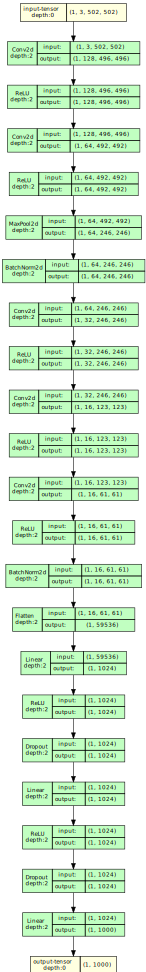

In [ ]:
model1_graph = torchview.draw_graph( model=model1, input_size=(1,)+input_dim )
model1_graph.visual_graph

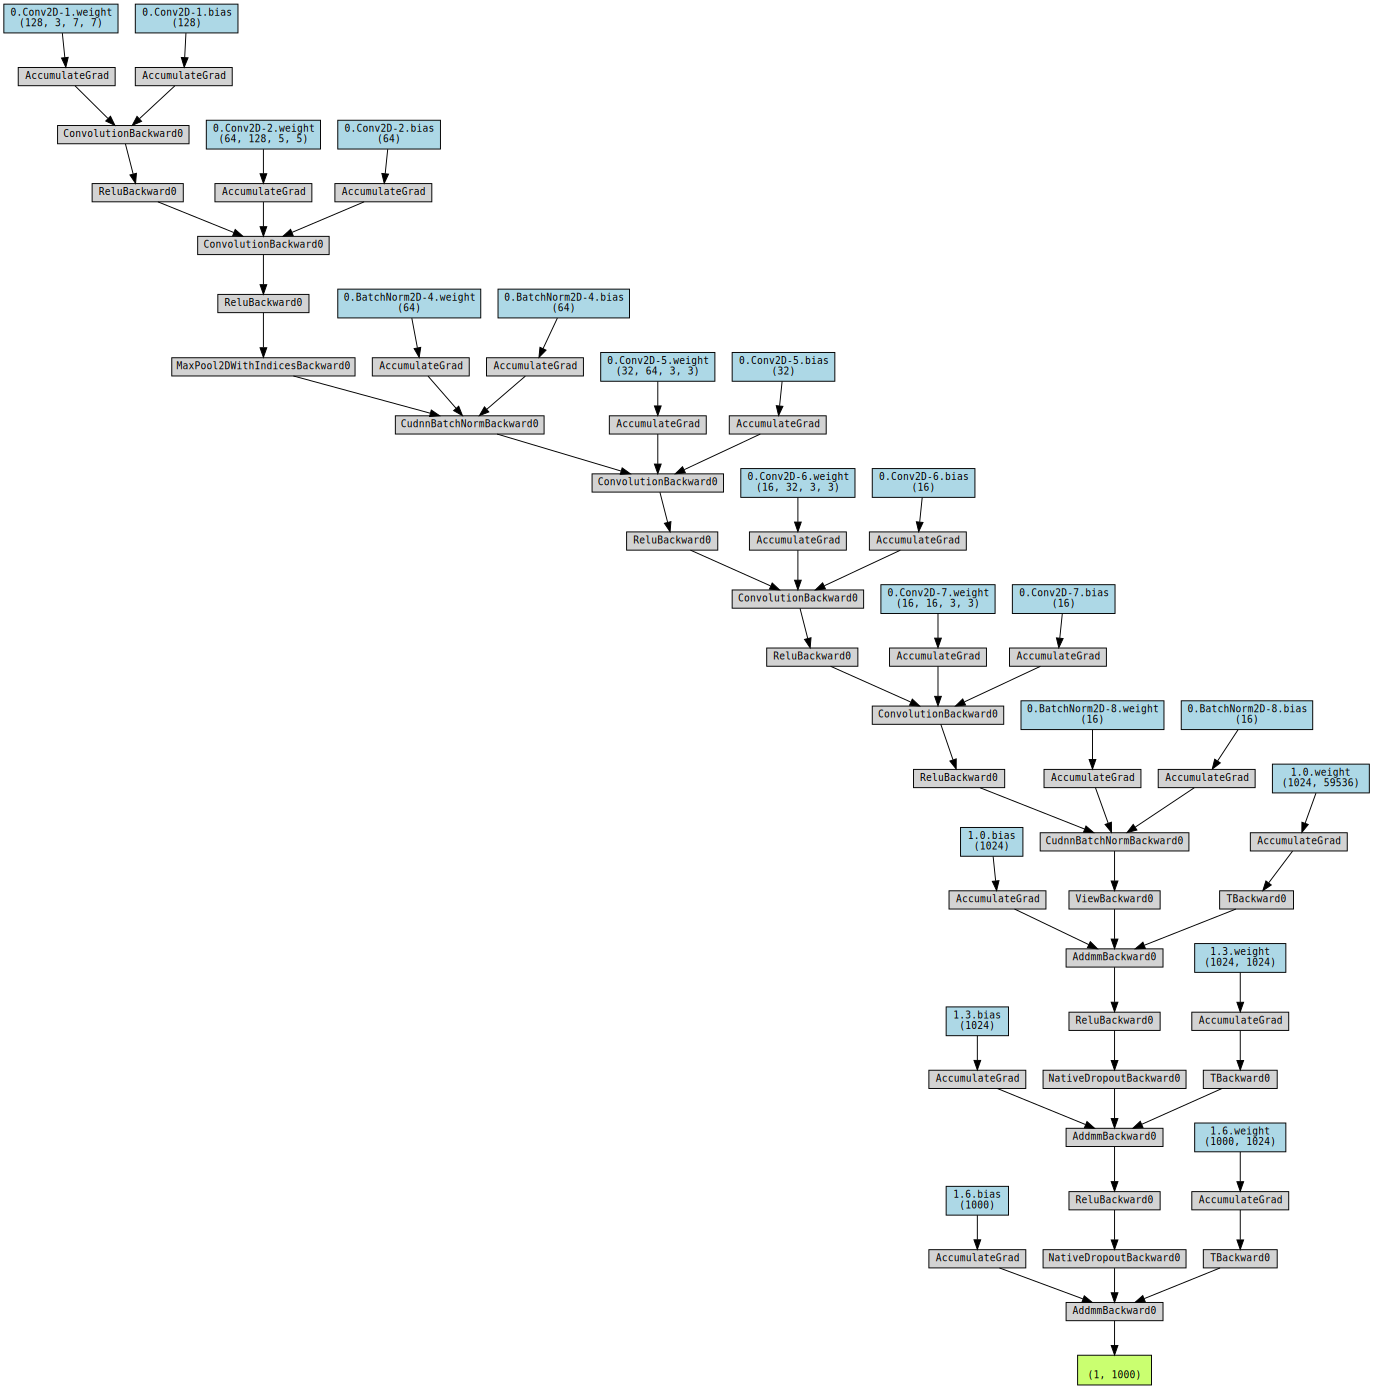

In [ ]:
dummy_input = torch.zeros(input_dim).to(device)
y = model1(dummy_input.unsqueeze(0))
torchviz.make_dot( y,
                   params=dict(model1.named_parameters()),
              )

## 2.2 Subclassing

Define the same model as Section 2.1:

In [ ]:
class MySequentialCNN(torch.nn.Module):
    def __init__(self, input_dim):
        # Call the parent's constructor method
        super().__init__()

        # --- Feature extractor ---
        self.features = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=input_dim[0], out_channels=128, kernel_size=7, padding='valid'),
                torch.nn.ReLU(),

                torch.nn.Conv2d(in_channels=128, out_channels=64, kernel_size=5, padding='valid'),
                torch.nn.ReLU(),

                torch.nn.MaxPool2d(kernel_size=2),
                torch.nn.BatchNorm2d(num_features=64),

                torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
                torch.nn.ReLU(),

                torch.nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1, stride=2),
                torch.nn.ReLU(),

                torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=0, stride=2),
                torch.nn.ReLU(),

                torch.nn.BatchNorm2d(num_features=16),
                torch.nn.Flatten()
        )

        # --- Automatic Feature Size Calculation ---
        self.feature_size = self._get_feature_size(input_dim)

        # --- Classifier ---
        self.classifier = torch.nn.Sequential(
                torch.nn.Linear(self.feature_size, 1024),
                torch.nn.ReLU(),
                torch.nn.Dropout(0.5),
                torch.nn.Linear(1024, 1024),
                torch.nn.ReLU(),
                torch.nn.Dropout(0.5),
                torch.nn.Linear(1024, output_dim)
        )

    def _get_feature_size(self, input_dim):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_dim)
            dummy_output = self.features(dummy_input)

            # Total elements = channels * height * width of the final feature map
            return dummy_output.numel()

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
model2 = MySequentialCNN(input_dim).to(device)
model2

MySequentialCNN(
  (features): Sequential(
    (0): Conv2d(3, 128, kernel_size=(7, 7), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=valid)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (11): ReLU()
    (12): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=59536, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=1024, bias=T

Inspect the model:

In [ ]:
torchinfo.summary(model2)

Layer (type:depth-idx)                   Param #
MySequentialCNN                          --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       18,944
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       204,864
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─BatchNorm2d: 2-6                  128
│    └─Conv2d: 2-7                       18,464
│    └─ReLU: 2-8                         --
│    └─Conv2d: 2-9                       4,624
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      2,320
│    └─ReLU: 2-12                        --
│    └─BatchNorm2d: 2-13                 32
│    └─Flatten: 2-14                     --
├─Sequential: 1-2                        --
│    └─Linear: 2-15                      60,965,888
│    └─ReLU: 2-16                        --
│    └─Dropout: 2-17                     --
│    └─Linear: 2-18                      1,

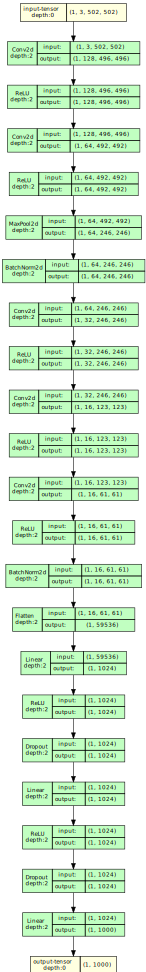

In [ ]:
model2_graph = torchview.draw_graph( model=model2, input_size=(1,)+input_dim )
model2_graph.visual_graph

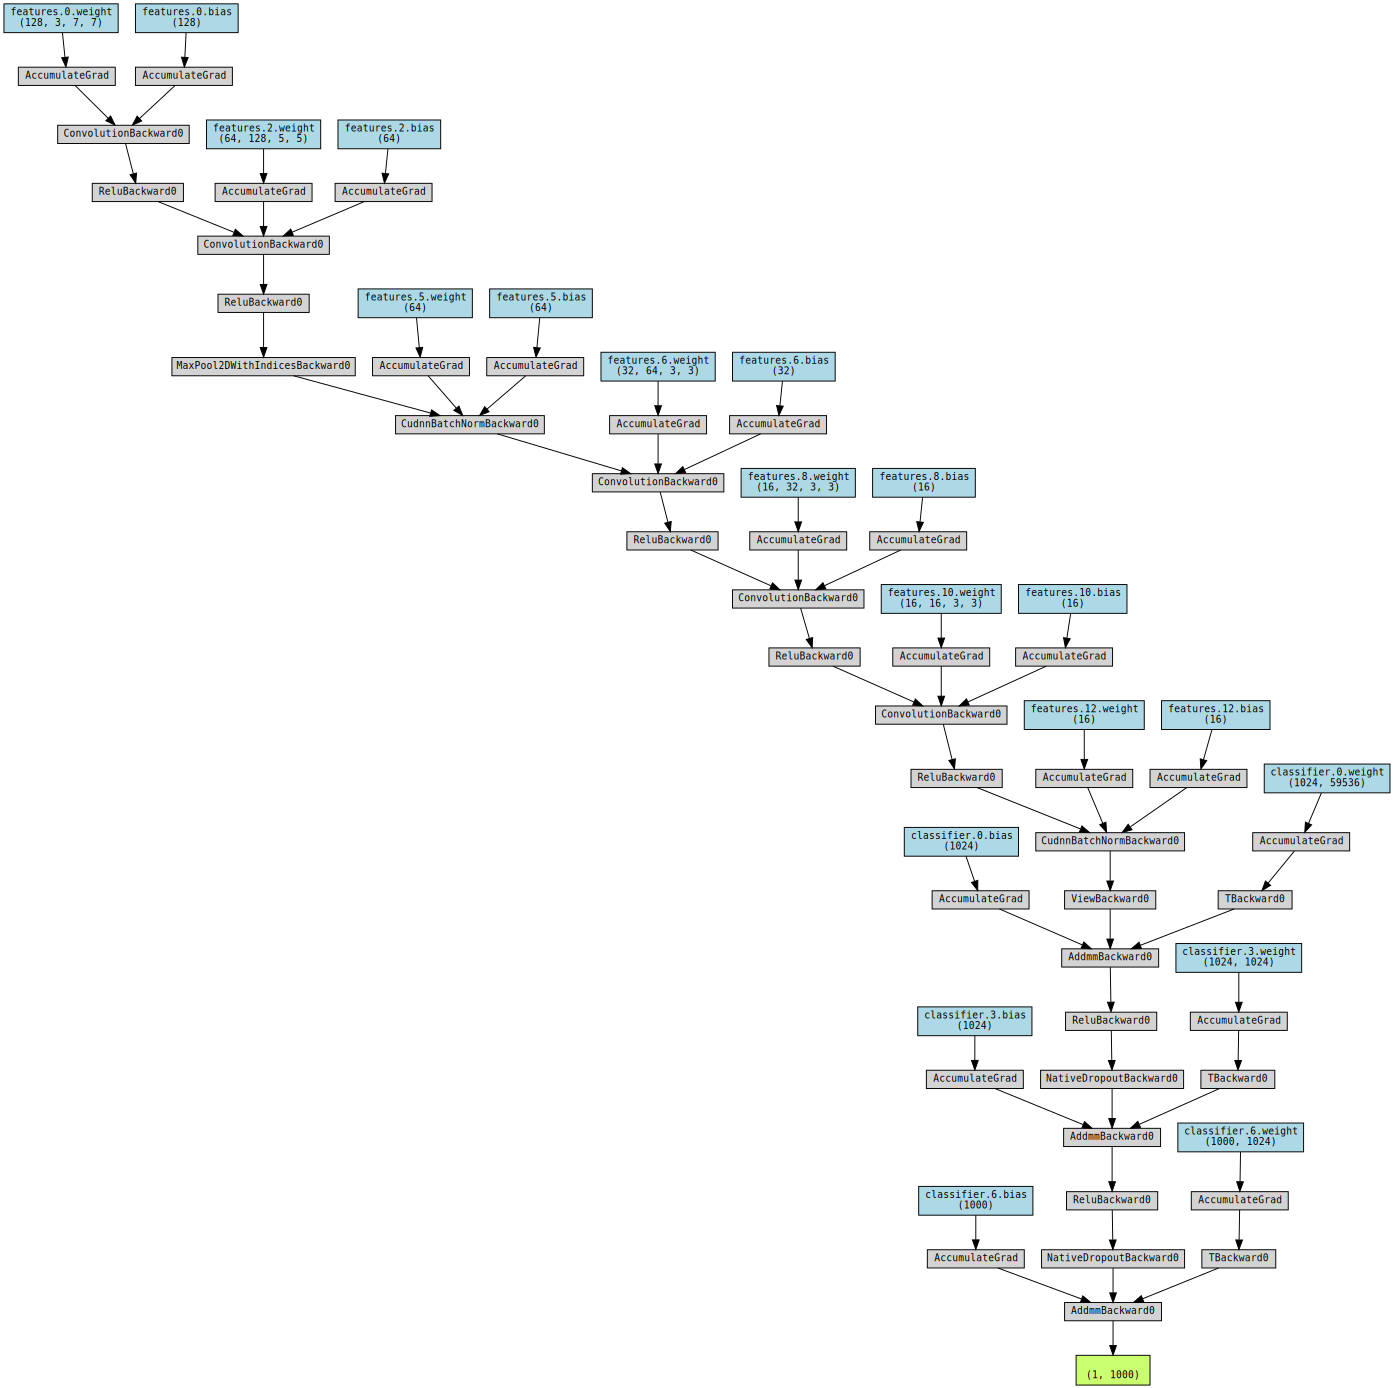

In [ ]:
dummy_input = torch.zeros(input_dim).to(device)
y = model2(dummy_input.unsqueeze(0))
torchviz.make_dot( y,
                   params=dict(model2.named_parameters()),
              )

# 3. Test using the models (with random inputs)

In [ ]:
batch_size = 7

# Create one batch of random input data
# The * unpacking works the same for tuples in torch.rand
x = torch.rand(batch_size, *input_dim).to(torch.float32).to(device)

print(f"{x.shape = }, {x.dtype = }, {x.min() = :.4f}, {x.max() = :.4f}")

x.shape = torch.Size([7, 3, 502, 502]), x.dtype = torch.float32, x.min() = 0.0000, x.max() = 1.0000


In [ ]:
%%timeit

# Pass the data to model1 (created by Sequential API)
y_pred1 = model1( x )
print(f"{y_pred1.shape = }, {y_pred1.dtype = }, {y_pred1.min() = :.4f}, {y_pred1.max() = :.4f}")

y_pred1.shape = torch.Size([7, 1000]), y_pred1.dtype = torch.float32, y_pred1.min() = -0.7028, y_pred1.max() = 0.6810
y_pred1.shape = torch.Size([7, 1000]), y_pred1.dtype = torch.float32, y_pred1.min() = -0.7154, y_pred1.max() = 0.7528
y_pred1.shape = torch.Size([7, 1000]), y_pred1.dtype = torch.float32, y_pred1.min() = -0.8447, y_pred1.max() = 0.6837
y_pred1.shape = torch.Size([7, 1000]), y_pred1.dtype = torch.float32, y_pred1.min() = -0.6912, y_pred1.max() = 0.7000
y_pred1.shape = torch.Size([7, 1000]), y_pred1.dtype = torch.float32, y_pred1.min() = -0.6860, y_pred1.max() = 0.6310
y_pred1.shape = torch.Size([7, 1000]), y_pred1.dtype = torch.float32, y_pred1.min() = -0.6570, y_pred1.max() = 0.6393
y_pred1.shape = torch.Size([7, 1000]), y_pred1.dtype = torch.float32, y_pred1.min() = -0.6651, y_pred1.max() = 0.7265
y_pred1.shape = torch.Size([7, 1000]), y_pred1.dtype = torch.float32, y_pred1.min() = -0.6599, y_pred1.max() = 0.6830
227 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 1

In [ ]:
%%timeit

# Pass the data to model1 (created by Subclassing)
y_pred2 = model2( x )
print(f"{y_pred2.shape = }, {y_pred2.dtype = }, {y_pred2.min() = :.4f}, {y_pred2.max() = :.4f}")

y_pred2.shape = torch.Size([7, 1000]), y_pred2.dtype = torch.float32, y_pred2.min() = -0.9323, y_pred2.max() = 0.7480
y_pred2.shape = torch.Size([7, 1000]), y_pred2.dtype = torch.float32, y_pred2.min() = -0.7926, y_pred2.max() = 0.7640
y_pred2.shape = torch.Size([7, 1000]), y_pred2.dtype = torch.float32, y_pred2.min() = -0.6911, y_pred2.max() = 0.6661
y_pred2.shape = torch.Size([7, 1000]), y_pred2.dtype = torch.float32, y_pred2.min() = -0.6736, y_pred2.max() = 0.7139
y_pred2.shape = torch.Size([7, 1000]), y_pred2.dtype = torch.float32, y_pred2.min() = -0.6687, y_pred2.max() = 0.7339
y_pred2.shape = torch.Size([7, 1000]), y_pred2.dtype = torch.float32, y_pred2.min() = -0.6465, y_pred2.max() = 0.6290
y_pred2.shape = torch.Size([7, 1000]), y_pred2.dtype = torch.float32, y_pred2.min() = -0.8053, y_pred2.max() = 0.6652
y_pred2.shape = torch.Size([7, 1000]), y_pred2.dtype = torch.float32, y_pred2.min() = -0.7701, y_pred2.max() = 0.6865
229 ms ± 718 µs per loop (mean ± std. dev. of 7 runs, 1 